In [27]:
# Cell 1: Load sequence data and labels, perform strict sanity checks
import os
import numpy as np
from collections import Counter

# Adjust these paths if your files live elsewhere
X_PATH = r"C:\Users\user\Desktop\GaitLab\GaitLab\src\keypoints_csv\ts_data\X_seq_len64_stride32.npy"
y_PATH = r"C:\Users\user\Desktop\GaitLab\GaitLab\src\keypoints_csv\ts_data\y_seq_len64_stride32.npy"
META_PATH = r"C:\Users\user\Desktop\GaitLab\GaitLab\src\keypoints_csv\ts_data\meta_seq_len64_stride32.csv"  # optional

# 1) Load
X = np.load(X_PATH, allow_pickle=True)
y = np.load(y_PATH, allow_pickle=True)

# 2) Basic info
print(">>> Basic shapes")
print("X shape:", X.shape)   # expected (N, timesteps, features)
print("y shape:", y.shape)

# 3) Numeric checks
n_nans = int(np.isnan(X).sum())
n_infs = int(np.isinf(X).sum())
print("\n>>> Missing / invalid values")
print("Total NaNs in X:", n_nans)
print("Total Infs in X:", n_infs)

# 4) Value range (ignore NaNs)
if n_nans < X.size:
    print("\n>>> Value range (ignoring NaNs):")
    print("min:", float(np.nanmin(X)), "max:", float(np.nanmax(X)))
else:
    print("\n>>> All values are NaN in X — need to fix source extraction.")

# 5) Class distribution (text labels expected)
try:
    counts = Counter(y)
    print("\n>>> Label distribution (counts):")
    for k, v in counts.most_common():
        print(f"  {k}: {v}")
except Exception as e:
    print("\n>>> Could not compute label counts (labels may be numeric). Error:", e)
    print("Unique labels:", np.unique(y))

# 6) Show a tiny sample (first sequence first timestep and its label)
print("\n>>> Sample data (first sequence, first timestep, first 8 feature values):")
print(X[0, 0, :8])
print("Corresponding label (y[0]):", y[0])

# 7) Optional: show meta file head if present
if os.path.exists(META_PATH):
    try:
        import pandas as pd
        meta = pd.read_csv(META_PATH)
        print("\n>>> meta file sample:")
        display(meta.head(3))
    except Exception as e:
        print("\n>>> meta file exists but couldn't be read (pandas error):", e)

# 8) Keep these variables in memory for next cells:
# X, y


>>> Basic shapes
X shape: (2204, 64, 21)
y shape: (2204,)

>>> Missing / invalid values
Total NaNs in X: 141056
Total Infs in X: 0

>>> Value range (ignoring NaNs):
min: -7.0007123947143555 max: 68.93437957763672

>>> Label distribution (counts):
  KOA_Severe: 634
  KOA_Mild: 506
  KOA_Early: 336
  PD_Early: 213
  Normal: 208
  PD_Mild: 170
  PD_Severe: 57
  NonAssistive: 55
  Assistive: 25

>>> Sample data (first sequence, first timestep, first 8 feature values):
[0.32312822 0.47143033 0.38068298 0.10326837 0.5822616  0.30932415
        nan 0.20501016]
Corresponding label (y[0]): KOA_Early

>>> meta file exists but couldn't be read (pandas error): cannot import name 'arrow_table_to_pandas' from 'pandas.io._util' (c:\Users\user\Desktop\GaitLab\GaitEnv\Lib\site-packages\pandas\io\_util.py)


In [33]:
# Cell 2: Handle NaNs, encode labels, and split dataset
# Note: pandas is already imported in previous cell, so we don't need to import it again
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# --- Step 1: Handle NaNs ---
# Replace NaNs with the median value per feature across all frames
X_fixed = np.copy(X)
for feat_idx in range(X_fixed.shape[2]):
    feat_values = X_fixed[:, :, feat_idx].flatten()
    median_val = np.nanmedian(feat_values)
    if np.isnan(median_val):  # if all NaN in that column
        median_val = 0.0
    X_fixed[:, :, feat_idx] = np.nan_to_num(X_fixed[:, :, feat_idx], nan=median_val)

print("✅ NaNs handled.")
print("Remaining NaNs:", np.isnan(X_fixed).sum())

# --- Step 2: Encode labels ---
le = LabelEncoder()
y_encoded = le.fit_transform(y)
class_names = le.classes_
print("\nEncoded class names:", class_names)

# --- Step 3: Train/Val/Test split ---
X_train, X_temp, y_train, y_temp = train_test_split(
    X_fixed, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("\nData split completed:")
print("Train:", X_train.shape, " Val:", X_val.shape, " Test:", X_test.shape)

# --- Step 4: Feature scaling (per feature column) ---
scaler = StandardScaler()
X_train_reshaped = X_train.reshape(-1, X_train.shape[2])
X_val_reshaped = X_val.reshape(-1, X_val.shape[2])
X_test_reshaped = X_test.reshape(-1, X_test.shape[2])

X_train_scaled = scaler.fit_transform(X_train_reshaped).reshape(X_train.shape)
X_val_scaled = scaler.transform(X_val_reshaped).reshape(X_val.shape)
X_test_scaled = scaler.transform(X_test_reshaped).reshape(X_test.shape)

print("\n✅ Scaling complete.")
print("Feature value range after scaling (train):", np.min(X_train_scaled), "to", np.max(X_train_scaled))


C:\Users\user\AppData\Local\Temp\ipykernel_10604\3388182371.py:11: RuntimeWarning: All-NaN slice encountered
  median_val = np.nanmedian(feat_values)


✅ NaNs handled.
Remaining NaNs: 0

Encoded class names: ['Assistive' 'KOA_Early' 'KOA_Mild' 'KOA_Severe' 'NonAssistive' 'Normal'
 'PD_Early' 'PD_Mild' 'PD_Severe']

Data split completed:
Train: (1763, 64, 21)  Val: (220, 64, 21)  Test: (221, 64, 21)

✅ Scaling complete.
Feature value range after scaling (train): -6.8054714 to 64.63383


In [40]:
# Cell 3: Define and Visualize the Teacher Model (High-Capacity Temporal + Transformer Network)

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.utils import plot_model
import numpy as np

def build_teacher_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # --- Temporal Convolutional Layers ---
    x = layers.Conv1D(128, kernel_size=5, padding='causal', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv1D(256, kernel_size=3, padding='causal', activation='relu', dilation_rate=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    # --- Transformer Encoder Block ---
    attn = layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
    x = layers.Add()([x, attn])
    x = layers.LayerNormalization()(x)

    ff = layers.Dense(256, activation='relu')(x)
    ff = layers.Dense(256)(ff)
    x = layers.Add()([x, ff])
    x = layers.LayerNormalization()(x)

    # --- Global Pooling ---
    x = layers.GlobalAveragePooling1D()(x)

    # --- Classification Head ---
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs, name="Teacher_LVM_Model")
    return model


# --- Build & Compile ---
input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = len(np.unique(y_train))

teacher = build_teacher_model(input_shape, num_classes)
teacher.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# --- Display Summary ---
teacher.summary()

# --- Visualize Model Architecture (optional) ---
print("\nAttempting to visualize model...")
try:
    import os
    from IPython.display import Image, display

    plot_path = "teacher_model_architecture.png"
    plot_model(
        teacher,
        to_file=plot_path,
        show_shapes=True,
        show_layer_names=True,
        dpi=100
    )

    if os.path.exists(plot_path):
        display(Image(filename=plot_path))
        print(f"✅ Model visualization saved to: {plot_path}")
    else:
        print("⚠️ Visualization file not found — likely missing Graphviz or pydot.")
except Exception as e:
    print(f"⚠️ Skipping visualization due to error: {e}")
    print("👉 To enable visualization, install Graphviz & pydot:")
    print("   pip install graphviz pydot")


Model: "Teacher_LVM_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 64, 21)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 64, 128)   │     13,568 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 128)   │        512 │ conv1d_12[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 64, 128)   │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 64, 256)   │     98,560 │ dropout_24[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 256)   │      1,024 │ conv1d_13[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 64, 256)   │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 64, 256)   │    263,168 │ dropout_25[0][0], │
│ (MultiHeadAttentio… │                   │            │ dropout_25[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_17 (Add)        │ (None, 64, 256)   │          0 │ dropout_25[0][0], │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 256)   │        512 │ add_17[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 64, 256)   │     65,792 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 64, 256)   │     65,792 │ dense_24[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_18 (Add)        │ (None, 64, 256)   │          0 │ layer_normalizat… │
│                     │                   │            │ dense_25[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 256)   │        512 │ add_18[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 256)       │     65,792 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_27          │ (None, 256)       │          0 │ dense_26[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 9)         │      2,313 │ dropout_27[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 577,545 (2.20 MB)

 Trainable params: 576,777 (2.20 MB)

 Non-trainable params: 768 (3.00 KB)


Attempting to visualize model...
You must install pydot (`pip install pydot`) for `plot_model` to work.
⚠️ Visualization file not found — likely missing Graphviz or pydot.


In [41]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.metrics import classification_report

# --- Handle any remaining NaNs / Infs ---
X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
X_val   = np.nan_to_num(X_val, nan=0.0, posinf=0.0, neginf=0.0)
X_test  = np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0)

# --- Compute class weights to handle imbalance ---
unique_classes = np.unique(y_train)
class_weights_values = compute_class_weight(
    class_weight='balanced',
    classes=unique_classes,
    y=y_train
)
class_weights = dict(zip(unique_classes, class_weights_values))
print("✅ Class weights computed:", class_weights)

# --- Callbacks ---
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_teacher_model.keras', monitor='val_loss', save_best_only=True)

# --- Train Teacher ---
history_teacher = teacher.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,            # increase later if needed
    batch_size=16,        # CPU-friendly
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint],
    verbose=2
)

# --- Evaluate on Test Set ---
test_loss, test_acc = teacher.evaluate(X_test, y_test, verbose=0)
print(f"\nTeacher Test Accuracy: {test_acc*100:.2f}%")

# --- Detailed Classification Report ---
y_pred = np.argmax(teacher.predict(X_test), axis=1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))


✅ Class weights computed: {0: 9.794444444444444, 1: 0.728211482858323, 2: 0.48367626886145404, 3: 0.3863686171378479, 4: 4.452020202020202, 5: 1.180053547523427, 6: 1.1522875816993463, 7: 1.440359477124183, 8: 4.258454106280193}
Epoch 1/50
111/111 - 24s - 216ms/step - accuracy: 0.2547 - loss: 1.7104 - val_accuracy: 0.3364 - val_loss: 1.6205
Epoch 2/50
111/111 - 10s - 89ms/step - accuracy: 0.3590 - loss: 1.2789 - val_accuracy: 0.4000 - val_loss: 1.5207
Epoch 3/50
111/111 - 8s - 69ms/step - accuracy: 0.3988 - loss: 1.1350 - val_accuracy: 0.4591 - val_loss: 1.3668
Epoch 4/50
111/111 - 7s - 63ms/step - accuracy: 0.4509 - loss: 1.0440 - val_accuracy: 0.4864 - val_loss: 1.3145
Epoch 5/50
111/111 - 8s - 68ms/step - accuracy: 0.4600 - loss: 1.0103 - val_accuracy: 0.5136 - val_loss: 1.2534
Epoch 6/50
111/111 - 7s - 61ms/step - accuracy: 0.4714 - loss: 0.9448 - val_accuracy: 0.5227 - val_loss: 1.2368
Epoch 7/50
111/111 - 7s - 62ms/step - accuracy: 0.4923 - loss: 0.9155 - val_accuracy: 0.5091 - v

In [42]:
from tensorflow.keras import layers, models

def build_student_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # --- Smaller Conv1D block ---
    x = layers.Conv1D(32, 3, activation='relu', padding='same')(inputs)
    x = layers.Conv1D(32, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(2)(x)

    # --- Another Conv1D block ---
    x = layers.Conv1D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(2)(x)
    
    # --- Global Pooling and Dense ---
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    student_model = models.Model(inputs, outputs, name="Student")
    return student_model

# --- Create student ---
student = build_student_model(input_shape=(X_train.shape[1], X_train.shape[2]), num_classes=len(class_names))
student.summary()


Model: "Student"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 64, 21)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 64, 32)         │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 64, 32)         │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 32, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 32, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 16, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_7      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,105 (62.91 KB)

 Trainable params: 16,105 (62.91 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
import tensorflow as tf

temperature = 5.0
alpha = 0.7
batch_size = 16

# --- Compute teacher predictions once for the full training set ---
teacher_preds = teacher.predict(X_train, batch_size=batch_size)
teacher_preds_soft = tf.nn.softmax(teacher_preds / temperature)

# --- Create dataset including teacher soft targets ---
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train, teacher_preds_soft))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)

# --- Custom training step with distillation ---
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
kl_loss = tf.keras.losses.KLDivergence()

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

@tf.function
def train_step(x, y_true, teacher_soft):
    with tf.GradientTape() as tape:
        logits = student(x, training=True)
        hard_loss = loss_object(y_true, logits)
        soft_loss = kl_loss(teacher_soft, tf.nn.softmax(logits / temperature)) * (temperature ** 2)
        loss = alpha * soft_loss + (1 - alpha) * hard_loss
    grads = tape.gradient(loss, student.trainable_variables)
    optimizer.apply_gradients(zip(grads, student.trainable_variables))
    train_acc_metric.update_state(y_true, logits)
    return loss

# --- Training loop ---
epochs = 50
for epoch in range(epochs):
    train_acc_metric.reset_state()
    for step, (x_batch, y_batch, t_batch) in enumerate(train_dataset):
        loss = train_step(x_batch, y_batch, t_batch)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {loss:.4f} - Accuracy: {train_acc_metric.result().numpy():.4f}")

# --- Evaluate on test set ---
test_preds = student.predict(X_test, batch_size=batch_size)
test_acc = tf.keras.metrics.sparse_categorical_accuracy(y_test, test_preds)
print(f"Student Test Accuracy: {tf.reduce_mean(test_acc).numpy() * 100:.2f}%")


111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
Epoch 1/50 - Loss: 0.4461 - Accuracy: 0.3352
Epoch 2/50 - Loss: 0.4208 - Accuracy: 0.4634
Epoch 3/50 - Loss: 0.4283 - Accuracy: 0.5383
Epoch 4/50 - Loss: 0.4155 - Accuracy: 0.5837
Epoch 5/50 - Loss: 0.4555 - Accuracy: 0.6137
Epoch 6/50 - Loss: 0.2972 - Accuracy: 0.6410
Epoch 7/50 - Loss: 0.3546 - Accuracy: 0.6506
Epoch 8/50 - Loss: 0.2404 - Accuracy: 0.6761
Epoch 9/50 - Loss: 0.1048 - Accuracy: 0.6948
Epoch 10/50 - Loss: 0.1752 - Accuracy: 0.7056
Epoch 11/50 - Loss: 0.1793 - Accuracy: 0.7334
Epoch 12/50 - Loss: 0.3966 - Accuracy: 0.7544
Epoch 13/50 - Loss: 0.2337 - Accuracy: 0.7425
Epoch 14/50 - Loss: 0.0670 - Accuracy: 0.7669
Epoch 15/50 - Loss: 0.5001 - Accuracy: 0.7799
Epoch 16/50 - Loss: 0.0414 - Accuracy: 0.7799
Epoch 17/50 - Loss: 0.2156 - Accuracy: 0.7918
Epoch 18/50 - Loss: 0.1100 - Accuracy: 0.7981
Epoch 19/50 - Loss: 0.1630 - Accuracy: 0.8247
Epoch 20/50 - Loss: 0.0767 - Accuracy: 0.8361
Epoch 21/50 - Loss: 0.6178 - Accuracy: 0.8383
E

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


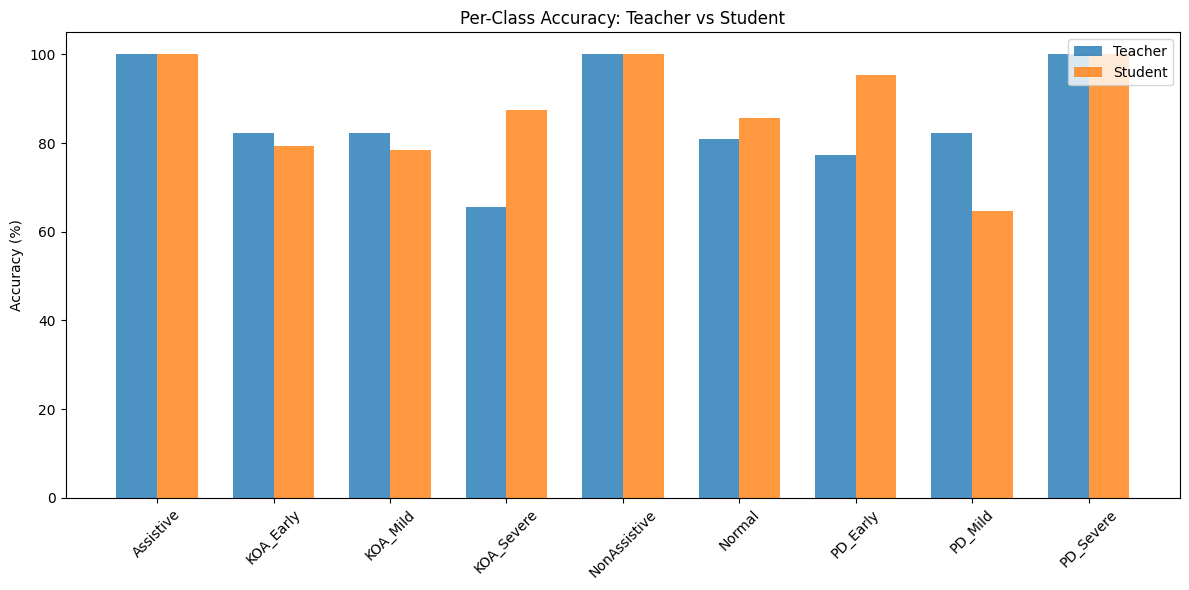

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# --- Compute predictions ---
teacher_preds = teacher.predict(X_test)
teacher_labels = np.argmax(teacher_preds, axis=1)

student_preds = student.predict(X_test)
student_labels = np.argmax(student_preds, axis=1)

# --- Class names ---
class_names = ['Assistive', 'KOA_Early', 'KOA_Mild', 'KOA_Severe', 
               'NonAssistive', 'Normal', 'PD_Early', 'PD_Mild', 'PD_Severe']

# --- Compute per-class accuracy ---
def per_class_accuracy(y_true, y_pred, classes):
    accs = []
    for i, cls in enumerate(classes):
        idx = np.where(y_true == i)[0]
        if len(idx) > 0:
            acc = np.mean(y_pred[idx] == y_true[idx])
            accs.append(acc)
        else:
            accs.append(np.nan)  # no samples for this class
    return np.array(accs)

teacher_accs = per_class_accuracy(y_test, teacher_labels, class_names)
student_accs = per_class_accuracy(y_test, student_labels, class_names)

# --- Plot comparison ---
x = np.arange(len(class_names))
width = 0.35

plt.figure(figsize=(12,6))
plt.bar(x - width/2, teacher_accs*100, width, label='Teacher', alpha=0.8)
plt.bar(x + width/2, student_accs*100, width, label='Student', alpha=0.8)
plt.xticks(x, class_names, rotation=45)
plt.ylabel('Accuracy (%)')
plt.title('Per-Class Accuracy: Teacher vs Student')
plt.ylim(0, 105)
plt.legend()
plt.tight_layout()
plt.show()


In [47]:
student.save("student_model.keras")


c:\Users\user\Desktop\GaitLab\GaitEnv\Lib\site-packages\keras\src\saving\serialization_lib.py:405: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:     loss=lambda y_true, y_pred: distillation_loss(y_true, y_pred, teacher_probs=teacher_preds_soft, 
                                                 temperature=temperature, alpha=alpha),

  return {key: serialize_keras_object(value) for key, value in obj.items()}
